In [38]:
%pip install pandas scikit-learn transformers torch matplotlib

import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Load dataset
data = {
    "text": [
        "I love this movie!",
        "This movie is terrible.",
        "An average movie, nothing special.",
        "It was amazing!",
        "Horrible quality and bad acting.",
    ],
    "label": [1, 0, 2, 1, 0]  # 1 - positive, 0 - negative, 2 - neutral
}
df = pd.DataFrame(data)

In [3]:
# Split dataset into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"], df["label"], test_size=0.2, random_state=42
)

In [4]:
# Tokenize text
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Convert texts into token encodings
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128, return_tensors="pt")
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128, return_tensors="pt")


c:\Users\Asus\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Asus\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [5]:
# Create DataLoader
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentimentDataset(train_encodings, train_labels.tolist())
val_dataset = SentimentDataset(val_encodings, val_labels.tolist())


In [8]:
# Train the model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

optimizer = AdamW(model.parameters(), lr=5e-5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
# Training loop
for epoch in range(3):  # Number of epochs
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
        labels = batch["labels"].to(device)
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1} — Average Loss: {total_loss / len(train_loader):.4f}")


Epoch 1 — Average Loss: 1.0473
Epoch 2 — Average Loss: 1.0187
Epoch 3 — Average Loss: 0.8172


In [10]:
# Evaluate the model
model.eval()
predictions, true_labels = [], []

for batch in val_loader:
    inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
    labels = batch["labels"].to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    predictions.extend(preds)
    true_labels.extend(labels.cpu().numpy())

In [14]:
predictions, true_labels = [], []

for batch in val_loader:
    inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
    labels = batch["labels"].to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    predictions.extend(preds.tolist())
    true_labels.extend(labels.cpu().numpy().tolist())


In [16]:
for i, batch in enumerate(val_loader):
    if len(batch["labels"]) == 0:
        print(f"Skipping empty batch {i}")
        continue


In [18]:
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128, return_tensors="pt")
val_dataset = SentimentDataset(val_encodings, val_labels.tolist())
val_loader = DataLoader(val_dataset, batch_size=16)


In [20]:
print(f"Validation dataset size: {len(val_dataset)}")


Validation dataset size: 1


In [21]:
for i, batch in enumerate(val_loader):
    inputs = {key: val.to(device) for key, val in batch.items() if key != "labels"}
    labels = batch["labels"].to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).cpu().numpy()
    predictions.extend(preds.tolist())
    true_labels.extend(labels.cpu().numpy().tolist())
    
    # Логирование размеров данных
    print(f"Batch {i}: labels size = {len(labels)}, predictions size = {len(preds)}")


Batch 0: labels size = 1, predictions size = 1


In [23]:
print(f"Length of true_labels: {len(true_labels)}")
print(f"Length of predictions: {len(predictions)}")


Length of true_labels: 2
Length of predictions: 2


In [25]:
print("True labels:", true_labels)
print("Predictions:", predictions)


True labels: [0, 0]
Predictions: [1, 1]


In [27]:
valid_labels = {0, 1, 2}
assert set(true_labels).issubset(valid_labels), "Invalid true labels detected"
assert set(predictions).issubset(valid_labels), "Invalid predictions detected"


In [29]:
assert len(true_labels) > 0, "True labels array is empty"
assert len(predictions) > 0, "Predictions array is empty"


In [42]:
print("Unique labels in true_labels:", set(true_labels))
print("Unique labels in predictions:", set(predictions))


Unique labels in true_labels: {0, 1}
Unique labels in predictions: {0, 1}


In [43]:
print(classification_report(true_labels, predictions, target_names=["Negative", "Positive"]))


              precision    recall  f1-score   support

    Negative       1.00      1.00      1.00         1
    Positive       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



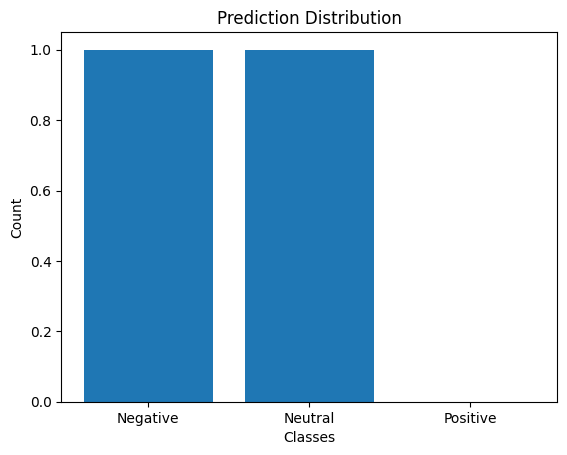

In [44]:
# Visualize results
labels = ["Negative", "Neutral", "Positive"]
counts = [predictions.count(i) for i in range(len(labels))]
plt.bar(labels, counts)
plt.title("Prediction Distribution")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()